In [ ]:
import sys
from pathlib import Path

ROOT = Path.cwd()
if (ROOT / "src").exists():
    sys.path.insert(0, str(ROOT))
else:
    sys.path.insert(0, str(ROOT.parent))

In [3]:
import numpy as np
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
from src.data_io import list_csv_files

from src.config import Config, CLASSES_12
from src.preprocess import load_and_clean_csv
from src.sequences import df_to_sequences
from collections import Counter
import os

In [ ]:
import src.config
print("config.py location:", src.config.__file__)

config.py location: C:\Users\Bilgesu Örten\OneDrive - Ankara Üniversitesi\Masaüstü\Backup_Time_Series_Classification\src\config.py


In [5]:
cfg = Config()

np.random.seed(cfg.seed)
tf.random.set_seed(cfg.seed)

class_to_id = {c: i for i, c in enumerate(CLASSES_12)}
num_classes = len(CLASSES_12)

all_files = list_csv_files(cfg.data_dir)
print("Found files:", len(all_files))
print(*all_files[:20], sep="\n")


Found files: 17
C:\Users\Bilgesu Örten\OneDrive - Ankara Üniversitesi\Masaüstü\Backup_Time_Series_Classification\data\multi_resolution\1day_sigma0.01.csv
C:\Users\Bilgesu Örten\OneDrive - Ankara Üniversitesi\Masaüstü\Backup_Time_Series_Classification\data\multi_resolution\1day_sigma0.02.csv
C:\Users\Bilgesu Örten\OneDrive - Ankara Üniversitesi\Masaüstü\Backup_Time_Series_Classification\data\multi_resolution\1day_sigma0.05.csv
C:\Users\Bilgesu Örten\OneDrive - Ankara Üniversitesi\Masaüstü\Backup_Time_Series_Classification\data\multi_resolution\1day_sigma0.07.csv
C:\Users\Bilgesu Örten\OneDrive - Ankara Üniversitesi\Masaüstü\Backup_Time_Series_Classification\data\multi_resolution\1day_sigma0.1.csv
C:\Users\Bilgesu Örten\OneDrive - Ankara Üniversitesi\Masaüstü\Backup_Time_Series_Classification\data\multi_resolution\1hour_sigma0.005.csv
C:\Users\Bilgesu Örten\OneDrive - Ankara Üniversitesi\Masaüstü\Backup_Time_Series_Classification\data\multi_resolution\1hour_sigma0.01.csv
C:\Users\Bilgesu

In [6]:
cfg = Config()

allowed_patterns = set(CLASSES_12) | {"no-pattern"}

test_path = all_files[0]

df = load_and_clean_csv(
    test_path,
    feature_cols=cfg.feature_cols,
    allowed_patterns=allowed_patterns,
    junk_cols=cfg.junk_cols,
    required_cols=cfg.required_cols,
)

X, y = df_to_sequences(
    df,
    feature_cols=cfg.feature_cols,
    seq_len=cfg.seq_len,
    class_to_id={c: i for i, c in enumerate(CLASSES_12)},
    min_group_len=cfg.min_group_len,
    max_seqs_per_file=cfg.max_seqs_per_file,
)

print("Test file:", test_path)
print("df shape:", df.shape)
print("patterns (top 10):")
print(df["pattern"].value_counts().head(10))

if X is None:
    print("No sequences produced from this file.")
else:
    print("Sequences produced:")
    print("X shape:", X.shape)
    print("y shape:", y.shape)
    print("labels example:", y[:10])

Test file: C:\Users\Bilgesu Örten\OneDrive - Ankara Üniversitesi\Masaüstü\Backup_Time_Series_Classification\data\multi_resolution\1day_sigma0.01.csv
df shape: (121604, 7)
patterns (top 10):
pattern
no-pattern       52277
BearButterfly    11109
BullButterfly     9051
BullGartley       7032
BearShark         7002
BearGartley       6500
BullShark         6148
BullCypher        4825
BullBat           4181
BearCrab          3904
Name: count, dtype: int64
Sequences produced:
X shape: (3225, 64, 5)
y shape: (3225,)
labels example: [ 9  7 10  4  9  4  1  9  5  4]


In [7]:
from src.config import Config
from pathlib import Path

cfg = Config()

DATA_DIR_ABS = cfg.data_dir.resolve()
print("Resolved data dir:", DATA_DIR_ABS)
print("Exists?", DATA_DIR_ABS.exists())

all_files = sorted([str(p) for p in DATA_DIR_ABS.glob("*.csv")])

EVAL_BASENAMES = {
    "1hour_sigma0.01.csv",
    "1minute_sigma0.005.csv",
    "1day_sigma0.02.csv"
}

EVAL_FILES = [f for f in all_files if Path(f).name in EVAL_BASENAMES]
train_files = [f for f in all_files if Path(f).name not in EVAL_BASENAMES]

print("Found files:", len(all_files))
print("Train files:", len(train_files))
print("Eval files:", len(EVAL_FILES))
print("Eval picked:", [Path(f).name for f in EVAL_FILES])


Resolved data dir: C:\Users\Bilgesu Örten\OneDrive - Ankara Üniversitesi\Masaüstü\Backup_Time_Series_Classification\data\multi_resolution
Exists? True
Found files: 17
Train files: 14
Eval files: 3
Eval picked: ['1day_sigma0.02.csv', '1hour_sigma0.01.csv', '1minute_sigma0.005.csv']


In [8]:
total = Counter()
per_file_counts = {}

allowed_patterns = set(CLASSES_12) | {"no-pattern"}

for path in all_files:
    df = load_and_clean_csv(
        path,
        feature_cols=cfg.feature_cols,
        allowed_patterns=allowed_patterns,
        junk_cols=cfg.junk_cols,
        required_cols=cfg.required_cols
    )

    X, y = df_to_sequences(
        df,
        feature_cols=cfg.feature_cols,
        seq_len=cfg.seq_len,
        class_to_id=class_to_id,
        min_group_len=cfg.min_group_len,
        max_seqs_per_file=cfg.max_seqs_per_file,
        pad_value=0.0
    )

    if X is None:
        print("No patterns found in:", os.path.basename(path))
        continue

    counts = Counter(y)
    per_file_counts[os.path.basename(path)] = len(y)
    total.update(counts)

print("Total sequences across files:", sum(per_file_counts.values()))
print("Per-file sequences (first 10):", list(per_file_counts.items())[:10])

inv = {v: k for k, v in class_to_id.items()}
print("Total label distribution:")
for k, v in total.most_common():
    print(inv[k], v)

Total sequences across files: 347783
Per-file sequences (first 10): [('1day_sigma0.01.csv', 3225), ('1day_sigma0.02.csv', 1453), ('1day_sigma0.05.csv', 370), ('1day_sigma0.07.csv', 229), ('1day_sigma0.1.csv', 117), ('1hour_sigma0.005.csv', 5523), ('1hour_sigma0.01.csv', 3225), ('1hour_sigma0.02.csv', 1453), ('1hour_sigma0.05.csv', 370), ('1minute_sigma0.001.csv', 178282)]
Total label distribution:
BearButterfly 47616
BullButterfly 46145
BearGartley 43593
BullGartley 42532
BearShark 34237
BullShark 33792
BullCypher 18607
BearCypher 17541
BullBat 17082
BullCrab 16480
BearBat 15157
BearCrab 15001


In [ ]:
import numpy as np
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

allowed_patterns = set(CLASSES_12) | {"no-pattern"}

for path in train_files:
    df = load_and_clean_csv(
        path,
        feature_cols=cfg.feature_cols,
        allowed_patterns=allowed_patterns,
        junk_cols=cfg.junk_cols,
        required_cols=cfg.required_cols
    )

    X, y = df_to_sequences(
        df,
        feature_cols=cfg.feature_cols,
        seq_len=cfg.seq_len,
        class_to_id=class_to_id,         
        min_group_len=cfg.min_group_len,
        max_seqs_per_file=cfg.max_seqs_per_file,
        drop_no_pattern=True,
        pad_value=0.0
    )

    if X is None:
        continue

    Xp = X.reshape(-1, X.shape[-1])
    nonpad = ~(np.all(Xp == 0.0, axis=1))  # ignore padded rows
    if nonpad.any():
        scaler.partial_fit(Xp[nonpad])

def scale_X(X):
    s, t, f = X.shape
    X2 = X.reshape(-1, f)
    X2 = scaler.transform(X2)
    return X2.reshape(s, t, f).astype(np.float32)

In [ ]:
# quick test
df = load_and_clean_csv(
    train_files[0],
    feature_cols=cfg.feature_cols,
    allowed_patterns=set(CLASSES_12) | {"no-pattern"},
    junk_cols=cfg.junk_cols,
    required_cols=cfg.required_cols
)

X, y = df_to_sequences(
    df,
    feature_cols=cfg.feature_cols,
    seq_len=cfg.seq_len,
    class_to_id=class_to_id
)

X_scaled = scale_X(X)
print(X.shape, X_scaled.shape, y.shape)

(3225, 64, 5) (3225, 64, 5) (3225,)


In [ ]:
from tensorflow.keras.optimizers import Adam
from src.models import build_liu_si_cnn_bilstm

cnn_lstm = build_liu_si_cnn_bilstm(
    seq_len=cfg.seq_len,
    num_features=len(cfg.feature_cols),
    num_classes=len(CLASSES_12),
    filters=64,
    module_dropout=0.1,
    head_dropout=0.3,
    lstm_units=64,
    bidirectional=True,
    modules=("m7","m10","m15")   # full model
    # modules=("m7","m15")       # ablation: without m10
    # modules=("m10","m15")      # ablation: without m7
    # modules=("m7","m10")       # ablation: without m15
)

cnn_lstm.compile(
    optimizer=Adam(3e-4),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

cnn_lstm.summary()

Model: "LiuSi_CNN_BiLSTM_m7_m10_m15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input (InputLayer)            │ (None, 64, 5)             │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ module10_conv_k3_d1 (Conv1D)  │ (None, 64, 64)            │             960 │ input[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ module15_conv_k3_d1 (Conv1D)  │ (None, 64, 64)            │             960 │ input[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ module10_bn_k3_d1             │ (None, 64, 64)            │             256 │ module10_conv_k3_d1[0][0]  │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ module15_bn_k3_d1             │ (None, 64, 64)            │             256 │ module15_conv_k3_d1[0][0]  │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ module10_relu_k3_d1 (ReLU)    │ (None, 64, 64)            │               0 │ module10_bn_k3_d1[0][0]    │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ module15_relu_k3_d1 (ReLU)    │ (None, 64, 64)            │               0 │ module15_bn_k3_d1[0][0]    │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ module10_drop_k3_d1 (Dropout) │ (None, 64, 64)            │               0 │ module10_relu_k3_d1[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ module15_drop_k3_d1 (Dropout) │ (None, 64, 64)            │               0 │ module15_relu_k3_d1[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ module7_conv_k3_d1 (Conv1D)   │ (None, 64, 64)            │             960 │ input[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ module10_conv_k3_d2 (Conv1D)  │ (None, 64, 64)            │          12,288 │ module10_drop_k3_d1[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ module15_conv_k3_d2 (Conv1D)  │ (None, 64, 64)            │          12,288 │ module15_drop_k3_d1[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ module7_bn_k3_d1              │ (None, 64, 64)            │             256 │ module7_conv_k3_d1[0][0]   │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ module10_bn_k3_d2             │ (None, 64, 64)            │             256 │ module10_conv_k3_d2[0][0]  │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ module15_bn_k3_d2             │ (None, 64, 64)            │             256 │ module15_conv_k3_d2[0][0]  │
│ (BatchNormalization)          │                           │               

 Total params: 149,900 (585.55 KB)

 Trainable params: 148,748 (581.05 KB)

 Non-trainable params: 1,152 (4.50 KB)

In [12]:
from src.config import Config, CLASSES_12
from src.data_io import list_csv_files
from src.splits import split_train_eval_files

cfg = Config()
all_files = list_csv_files(cfg.data_dir)

EVAL_BASENAMES = {"1hour_sigma0.01.csv", "1minute_sigma0.005.csv", "1day_sigma0.02.csv"}
train_files, eval_files = split_train_eval_files(all_files, EVAL_BASENAMES)

print("Train files:", len(train_files))
print("Eval files:", len(eval_files))


Train files: 14
Eval files: 3


In [13]:
import numpy as np
from src.weights import compute_balanced_class_weights
from src.datasets import make_load_xy_fn
from src.config import CLASSES_12

# load_xy_fn factory
load_xy_fn = make_load_xy_fn(
    feature_cols=cfg.feature_cols,
    seq_len=cfg.seq_len,
    class_to_id=class_to_id,
    scaler=scaler,
    junk_cols=cfg.junk_cols,
    required_cols=cfg.required_cols,
    min_group_len=cfg.min_group_len,
    max_seqs_per_file=cfg.max_seqs_per_file,
    drop_no_pattern=True,
    pad_value=0.0
)

VAL_TARGET_SEQS = 4000

X_val_list, y_val_list = [], []
for path in train_files:
    X, y = load_xy_fn(path)
    if X is None:
        continue
    X_val_list.append(X)
    y_val_list.append(y)
    if sum(len(a) for a in y_val_list) >= VAL_TARGET_SEQS:
        break

X_val = np.concatenate(X_val_list, axis=0)
y_val = np.concatenate(y_val_list, axis=0)

idx = np.random.permutation(len(X_val))
X_val, y_val = X_val[idx], y_val[idx]
X_val, y_val = X_val[:VAL_TARGET_SEQS], y_val[:VAL_TARGET_SEQS]

print("Validation set:", X_val.shape, y_val.shape)

# class weights from all training labels
y_all_train = []
for path in train_files:
    _, y = load_xy_fn(path)
    if y is not None:
        y_all_train.append(y)

y_all_train = np.concatenate(y_all_train, axis=0)
class_weight = compute_balanced_class_weights(y_all_train, num_classes=len(CLASSES_12))
print("Class weights:", class_weight)

Validation set: (4000, 64, 5) (4000,)
Class weights: {0: 1.8815603614135068, 1: 0.6114032588653324, 2: 1.90142621579051, 3: 1.6657772746873651, 4: 0.666932114431726, 5: 0.8498190557902147, 6: 1.669665240318119, 7: 0.6314930155382817, 8: 1.734787245986303, 9: 1.5673371472622888, 10: 0.6839720776231453, 11: 0.8535369437447523}


In [14]:
from src.train_loops import train_global_passes

cnn_lstm = train_global_passes(
    cnn_lstm,
    train_files=train_files,
    load_xy_fn=load_xy_fn,
    X_val=X_val,
    y_val=y_val,
    class_weight=class_weight,
    global_passes=20,
    epochs_per_file=1,
    batch_size=64,
    patience=3,
    verbose=0,
)


=== Global pass 1/20 ===
Validation -> loss: 1.9516 | acc: 0.2895
Improved val_loss. Saved best weights.

=== Global pass 2/20 ===
Validation -> loss: 1.7578 | acc: 0.3808
Improved val_loss. Saved best weights.

=== Global pass 3/20 ===
Validation -> loss: 1.6662 | acc: 0.4027
Improved val_loss. Saved best weights.

=== Global pass 4/20 ===
Validation -> loss: 1.9219 | acc: 0.3347
No improvement. patience 1/3

=== Global pass 5/20 ===
Validation -> loss: 1.6166 | acc: 0.4315
Improved val_loss. Saved best weights.

=== Global pass 6/20 ===
Validation -> loss: 1.6747 | acc: 0.4153
No improvement. patience 1/3

=== Global pass 7/20 ===
Validation -> loss: 1.8867 | acc: 0.3438
No improvement. patience 2/3

=== Global pass 8/20 ===
Validation -> loss: 1.6805 | acc: 0.4205
No improvement. patience 3/3
Early stopping triggered.
Restored best model weights from validation.


Eval set: (38748, 64, 5) (38748,)
               precision    recall  f1-score   support

      BearBat       0.40      0.30      0.35      1470
BearButterfly       0.49      0.52      0.50      5495
     BearCrab       0.35      0.51      0.41      1457
   BearCypher       0.26      0.50      0.34      2081
  BearGartley       0.53      0.39      0.45      4979
    BearShark       0.43      0.31      0.36      3933
      BullBat       0.39      0.28      0.32      1658
BullButterfly       0.51      0.45      0.47      5364
     BullCrab       0.43      0.43      0.43      1635
   BullCypher       0.23      0.54      0.32      2176
  BullGartley       0.56      0.31      0.40      4880
    BullShark       0.36      0.38      0.37      3620

     accuracy                           0.41     38748
    macro avg       0.41      0.41      0.39     38748
 weighted avg       0.45      0.41      0.41     38748

Overlap(train, eval) = set()


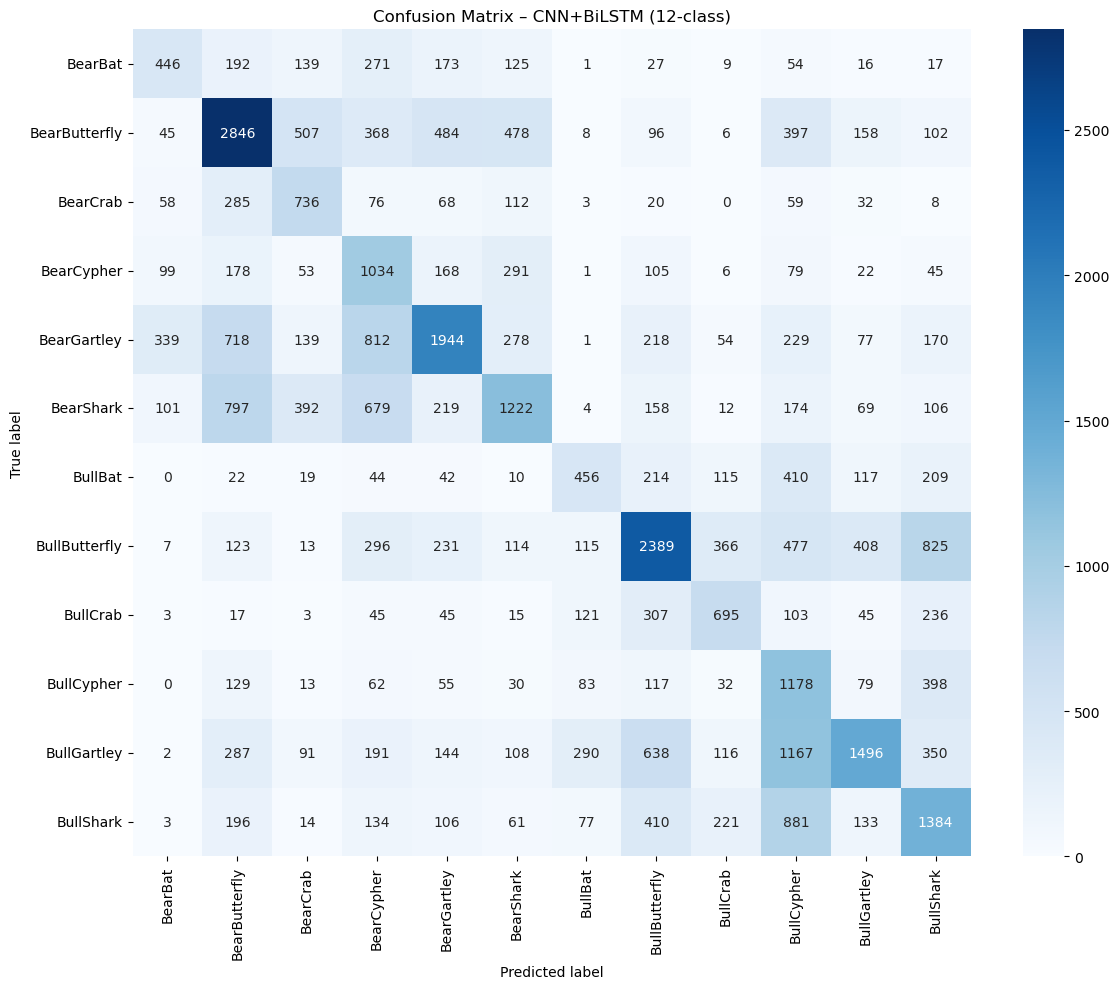

In [15]:
from src.evaluation import (
    build_eval_dataset,
    evaluate_model_multiclass,
    check_train_eval_overlap,
    plot_confusion_matrix
)

X_eval, y_eval = build_eval_dataset(eval_files, load_xy_fn)
print("Eval set:", X_eval.shape, y_eval.shape)

report, cm = evaluate_model_multiclass(cnn_lstm, X_eval, y_eval, CLASSES_12)
print(report)

print("Overlap(train, eval) =", check_train_eval_overlap(train_files, eval_files))

plot_confusion_matrix(cm, CLASSES_12, "Confusion Matrix – CNN+BiLSTM (12-class)")
